In [2558]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy

In [2560]:
xls_file = pd.ExcelFile("QPD_1micron_mar22.xlsx") #just load the excel file

In [2561]:
df_150mA = pd.read_excel(xls_file, '150mA')
df_200mA = pd.read_excel(xls_file, '200mA')
df_250mA = pd.read_excel(xls_file, '250mA')
df_300mA = pd.read_excel(xls_file, '300mA')
df_350mA = pd.read_excel(xls_file, '350mA')
df_400mA = pd.read_excel(xls_file, '400mA')
df_450mA = pd.read_excel(xls_file, '450mA')

In [2834]:
#global variables here:
frequency = 20 #Hz
meas_len = 5
time_display_start = 0 #x-axis start of all plots
time_display_stop = 0.5 #x-axis limit for all plots
workbook_name = 'tweezers_data.xlsx' #name of the excel file to write data into
sheet_name = '1micron' #name of excel sheet

picked_power = 450 #mA

In [2835]:
n_of_datapoints = len(df_150mA.index)
time = np.arange(0,meas_len,meas_len/n_of_datapoints) #create a new array with time series () 

In [2836]:
#convert dataframe to numpy array
arr_150mA = df_150mA.to_numpy()
arr_200mA = df_200mA.to_numpy()
arr_250mA = df_250mA.to_numpy()
arr_300mA = df_300mA.to_numpy()
arr_350mA = df_350mA.to_numpy()
arr_400mA = df_400mA.to_numpy()
arr_450mA = df_450mA.to_numpy()

Here the fun begins: a sheet (current aka laser power) is picked and from now on, I work with that one.
If a different sheet is needed, change the current value (e.g. arr_100mA to arr_200mA) in the following cell:

In [2837]:
qpd_laser_powers = np.array([150, 200, 250, 300, 350, 400, 450])

laser_power_index = int(np.where(qpd_laser_powers == picked_power)[0])
laser_power_arrays = [arr_150mA, arr_200mA, arr_250mA, arr_300mA, arr_350mA, arr_400mA, arr_450mA]
picked_dev = laser_power_arrays[laser_power_index]

In [2838]:
qpd_x = picked_dev[:,0]
qpd_y = picked_dev[:,1]
qpd_z = picked_dev[:,2]

pos_x = picked_dev[:,3]
pos_y = picked_dev[:,4]

Text(0, 0.5, 'QPD voltage (V)')

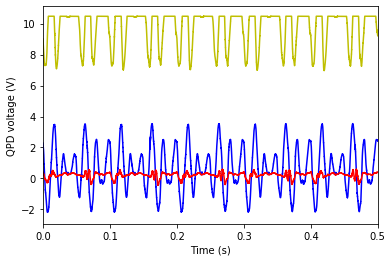

In [2839]:
plt.plot(time, qpd_x, 'b')
plt.plot(time, qpd_y, 'r')
plt.plot(time, qpd_z, 'y')
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time (s)')
plt.ylabel('QPD voltage (V)')

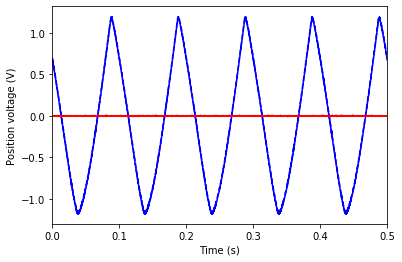

In [2840]:
plt.plot(time, pos_x, '--b')
plt.plot(time, pos_y, '--r')
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time (s)')
plt.ylabel('Position voltage (V)')

#the voltage has an obvious offset - following lines center it on zero pos. voltage
x_offset = max(pos_x)-(max(pos_x)-min(pos_x))/2
pos_x_center = pos_x - x_offset

y_offset = max(pos_y)-(max(pos_y)-min(pos_y))/2
pos_y_center = pos_y - y_offset

plt.plot(time, pos_x_center, 'b')
plt.plot(time, pos_y_center, 'r')

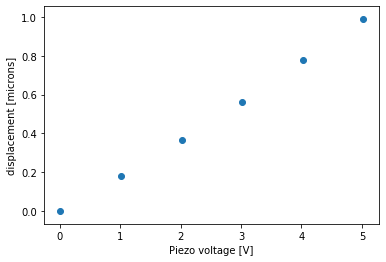

In [2841]:
#now I want to convert pos. voltage to actual displacement:
disp_volt = [0, 1.02, 2.02, 3.02, 4.02, 5.02] #taken manually
disp_microns = [0, 0.179, 0.365, 0.560, 0.778, 0.989] #taken manually (avg. of x, y motion)
plt.scatter(disp_volt, disp_microns)
plt.xlabel('Piezo voltage [V]')
plt.ylabel('displacement [microns]')
microns_per_volt,b = np.polyfit(disp_volt, disp_microns, 1) #do a linear fit and find slope

Text(0, 0.5, 'Fixed Bead displacement [microns]')

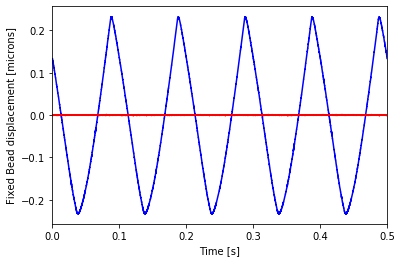

In [2842]:
x_displac = pos_x_center*microns_per_volt 
y_displac = pos_y_center*microns_per_volt 

plt.plot(time, x_displac, 'b')
plt.plot(time, y_displac, 'r')
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time [s]')
plt.ylabel('Fixed Bead displacement [microns]')

In [2843]:
#from now on, only one axis is being studied:
qpd_voltage = qpd_x
displac = x_displac

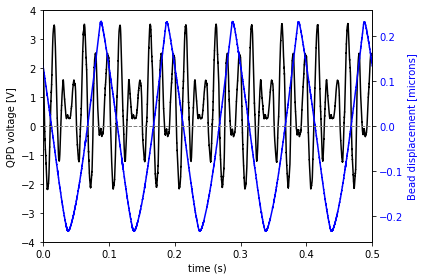

In [2844]:
# plot QPD voltage and fixed bead displacement on the same graph
fig, ax1 = plt.subplots()

#qpd voltage
ax1.set_xlabel('time (s)', color = 'black')
ax1.set_ylabel('QPD voltage [V]', color = 'black')
ax1.plot(time, qpd_voltage, color = 'black')
ax1.tick_params(axis='y')
ax1.set_ylim(-4,4)

#x-displacement
ax2 = ax1.twinx()
ax2.set_ylabel('Bead displacement [microns]', color = 'blue')  # we already handled the x-label with ax1
ax2.plot(time, displac, color = 'blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.xlim(time_display_start,time_display_stop)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axhline(y=0, linewidth=1, color='grey', linestyle = '--')

plt.show()

In [2845]:
#now I find the time stamp at which displacement is zero
#Then I look for extrema around this time in the qpd voltage, and do a linear fit of qpd data between these
#This should be done for many (all...?) periods, for approach from both sides independently 


In [2846]:
def hysteresis(zero_crossings):

# here I'm cleaning up a bit:
#in the qpd voltage data, zero crossings are not "clean" - there are multiple time instances (often temporally close to each other) at which the voltage crosses 0 (due to noise)
# here I find the "average length"-ish of the duration of stage motion (width of the square signal) in one direction (number of time steps, basically)
# if the number of time steps is lover than half of the "average", I delete the redundant zero crossings

    interval_diffs = []
    for i in range(0, len(zero_crossings)-1): #start with second zero-crossing index and find its distance from the previous one
        diff = zero_crossings[i+1] - zero_crossings[i]
        interval_diffs.append(diff) #For each index, store its distance from the previous
    interval_diffs = np.array(interval_diffs)
    avg_diffs = np.average(interval_diffs) #find the "average" width of the signal (it's NOT the average width though, just an orientation number to decide which ones to kick out!)

    indices_to_delete = []
    #scan through the qpd crossing indices again, now knowing what width each pulse should exceed and store the redundant indices 
    for i in range(0, len(zero_crossings)-1):
        diff = zero_crossings[i+1] - zero_crossings[i]
        if diff <= avg_diffs/2:
            indices_to_delete.append(i)

    zero_crossings = np.delete(zero_crossings, indices_to_delete) #delete redundant zero-crossing indices
    return(zero_crossings)

In [2847]:
def find_extrema(voltage_data, time):
# this function takes in qpd voltage array, time series array and returns arrays containing spikes in the voltage data (maxima, minima),
# indices of zero-crossings (up and down separately), and the total number of extremum points (positive OR negative spikes, whichever is smaller)

    voltage_zero_crossings = np.where(np.diff(np.sign(voltage_data)))[0] #get an array of indices at which a sign change occurs in the voltage signal

    voltage_zero_crossings = hysteresis(voltage_zero_crossings)

    global_max_voltage = max(voltage_data) #overall maximum of voltage signal
    global_min_voltage = min(voltage_data) #overall minimum of voltage signal
        
    maxima = []
    minima = []
    up_indices = []
    down_indices = []

    ## search for one local min and one max starts here
    for i in range(4, len(voltage_zero_crossings)-1):
        crossing_index = voltage_zero_crossings[i] 
        next_crossing = voltage_zero_crossings[i+1]
        previous_crossing = voltage_zero_crossings[i-1]

        local_max_voltage = 0
        local_max_index = 0

        local_min_voltage = 0
        local_min_index = 0

        flag1 = 0
        flag2 = 0

        threshold = 4/5 #this times the global max is the threshold for deciding if a peak is a local max. 

        #find index of local max around zero crossing
        for j in range(previous_crossing+1, next_crossing-1): #scan from last to next
            if voltage_data[j] > local_max_voltage and voltage_data[j] > global_max_voltage * threshold: 
                local_max_voltage = voltage_data[j]
                local_max_index = j
                flag1 = -1

        #find index of local min around zero crossing
        for k in list(reversed(range(previous_crossing+1, next_crossing-1))):
            if voltage_data[k] < local_min_voltage and voltage_data[k] < global_min_voltage * threshold:
                local_min_voltage = voltage_data[k]
                local_min_index = k
                flag2 = -1

        flag = flag1*flag2
        if local_max_voltage > 0:
            if [local_max_index, local_max_voltage] not in maxima:
                maxima.append([local_max_index, local_max_voltage])
        if local_min_voltage < 0:
            if [local_min_index, local_min_voltage] not in minima:
                minima.append([local_min_index, local_min_voltage])

        if flag and local_max_index > crossing_index and local_min_index < crossing_index:
            up_indices.append(crossing_index)
        elif flag and local_max_index < crossing_index and local_min_index > crossing_index:
            down_indices.append(crossing_index)



    if len(minima) < len(maxima):
        n_of_extrema = len(minima)
    else: 
        n_of_extrema = len(maxima)

    return([maxima, minima, up_indices, down_indices, n_of_extrema])

In [2848]:
[qpd_maxima, qpd_minima, qpd_up_indices, qpd_down_indices, qpd_n_of_extrema] = find_extrema(qpd_voltage, time)

Text(0, 0.5, 'QPD output voltage')

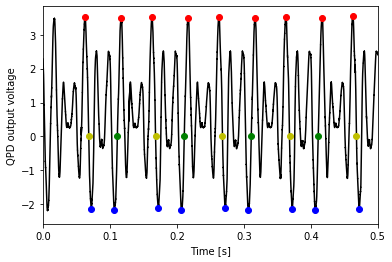

In [2849]:
plt.plot(time, qpd_voltage, 'black')
for i in range(len(qpd_up_indices)):
    plt.plot(time[qpd_up_indices[i]], 0, 'o', color='green') #mark relevant zero crossings (GREEN)
for i in range(len(qpd_down_indices)):
    plt.plot(time[qpd_down_indices[i]], 0, 'o', color='y') #mark relevant zero crossings (yellow)

for i in range(qpd_n_of_extrema):
    max_ind = int(qpd_maxima[i][0])
    max_qpd = qpd_maxima[i][1]

    min_ind = int(qpd_minima[i][0])
    min_qpd = qpd_minima[i][1]

    plt.plot(time[max_ind], max_qpd, 'o', color='red') #mark local QPD extreme (RED)
    plt.plot(time[min_ind], min_qpd, 'o', color='blue') #mark local QPD extreme (RED)

plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time [s]')
plt.ylabel('QPD output voltage')

In [2850]:
#Now I take the upwards and downwards sections individually and do a linear fit for each, averaging them in the end.
#This function EXPECTS ASSYMETRICAL SHAPE - meaning MIN -> MIN -> MAX -> MAX, etc.
def find_qpd_slopes(minima, maxima, n_of_extrema):
    minima = np.array(minima)
    maxima = np.array(maxima)

    up_slopes = []
    down_slopes = []

    #if the first extremum is a minimum
    if minima[0][0] < maxima[0][0]:
        for i in range(0, n_of_extrema-1, 2):
            rise = maxima[i, 1] - minima[i, 1] 
            run = (maxima[i, 0] - minima[i, 0])*(meas_len/n_of_datapoints)
            up_slope = rise/run
            up_slopes.append(up_slope)

        for i in range(0, n_of_extrema-1, 2):
            rise = minima[i+1, 1] - maxima[i+1, 1] 
            run = (minima[i+1, 0] - maxima[i+1, 0])*(meas_len/n_of_datapoints)
            down_slope = rise/run
            down_slopes.append(down_slope)
        print('starts with minimum')

    #if the first extremum is a maximum
    elif minima[0][0] > maxima[0][0]:
        for i in range(0, n_of_extrema-1, 2):
            rise = maxima[i+1, 1] - minima[i+1, 1] 
            run = (maxima[i+1, 0] - minima[i+1, 0])*(meas_len/n_of_datapoints)
            up_slope = rise/run
            up_slopes.append(up_slope)

        for i in range(0, n_of_extrema-1, 2):
            rise = minima[i, 1] - maxima[i, 1] 
            run = (minima[i, 0] - maxima[i, 0])*(meas_len/n_of_datapoints)
            down_slope = rise/run
            down_slopes.append(down_slope)
        print('starts with maximum')
    return([up_slopes, down_slopes])

In [2851]:
[qpd_up_slopes, qpd_down_slopes] = find_qpd_slopes(qpd_minima, qpd_maxima, qpd_n_of_extrema)

starts with maximum


In [2852]:
avg_qpd_up_slope = np.mean(qpd_up_slopes) #volts per second in the linear region
avg_qpd_down_slope = np.mean(qpd_down_slopes) #volts per second in the linear region
print("QPD avg. slope up = ",avg_qpd_up_slope, "volts per second")
print("QPD avg. slope down = ",avg_qpd_down_slope, "volts per second")

QPD avg. slope up =  565.7814613083201 volts per second
QPD avg. slope down =  -595.334030622457 volts per second


Now I need to do the same with position voltage - using the known time segments in which the qpd data is linear

In [2853]:
#calling a custom function to find maxima, minima, zero crossings etc. of the stage position voltage data
[pos_maxima, pos_minima, pos_up_indices, pos_down_indices, pos_n_of_extrema] = find_extrema(displac, time) 

Text(0, 0.5, 'Bead (position stage) displacement [microns]')

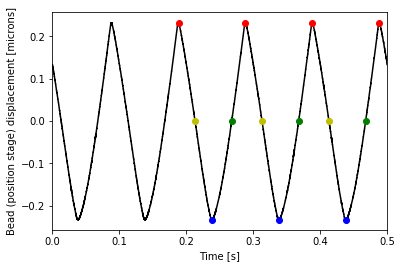

In [2854]:
#plotting displacement of the position stage (directly in microns already) versus time + pointing out extrema and points of zero crossing when the slope is positive and negative
# This serves as a visual control for the next step - calculating the slope of the triangular wave (AKA speed of the stage)
plt.plot(time, displac, 'black')
for i in range(len(pos_up_indices)):
    plt.plot(time[pos_up_indices[i]], 0, 'o', color='green') #mark relevant zero crossings (GREEN)
for i in range(len(pos_down_indices)):
    plt.plot(time[pos_down_indices[i]], 0, 'o', color='y') #mark relevant zero crossings (yellow)

for i in range(pos_n_of_extrema):
    pos_max_ind = int(pos_maxima[i][0])
    max_pos = pos_maxima[i][1]

    pos_min_ind = int(pos_minima[i][0])
    min_pos = pos_minima[i][1]

    plt.plot(time[pos_max_ind], max_pos, 'o', color='red') #mark local QPD extreme (RED)
    plt.plot(time[pos_min_ind], min_pos, 'o', color='blue') #mark local QPD extreme (RED)

plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time [s]')
plt.ylabel('Bead (position stage) displacement [microns]')

In [2855]:
#Now I take the upwards and downwards sections individually and do a linear fit for each, averaging them in the end.
#THIS FUNCTION EXPECTS A PERIODIC TRIANGULAR SHAPE!
def find_pos_slopes(minima, maxima, n_of_extrema):
    minima = np.array(minima)
    maxima = np.array(maxima)

    up_slopes = []
    down_slopes = []

    #if the first extremum is a minimum
    if minima[0][0] < maxima[0][0]:
        for i in range(0, n_of_extrema-1, 2):
            rise = maxima[i, 1] - minima[i, 1] 
            run = (maxima[i, 0] - minima[i, 0])*(meas_len/n_of_datapoints)
            up_slope = rise/run
            up_slopes.append(up_slope)

        for i in range(0, n_of_extrema-1, 2):
            rise = minima[i+1, 1] - maxima[i, 1] 
            run = (minima[i+1, 0] - maxima[i, 0])*(meas_len/n_of_datapoints)
            down_slope = rise/run
            down_slopes.append(down_slope)
        print('starts with minimum')

    #if the first extremum is a maximum
    elif minima[0][0] > maxima[0][0]:
        for i in range(0, n_of_extrema-1, 2):
            rise = maxima[i+1, 1] - minima[i, 1] 
            run = (maxima[i+1, 0] - minima[i, 0])*(meas_len/n_of_datapoints)
            up_slope = rise/run
            up_slopes.append(up_slope)

        for i in range(0, n_of_extrema-1, 2):
            rise = minima[i, 1] - maxima[i, 1] 
            run = (minima[i, 0] - maxima[i, 0])*(meas_len/n_of_datapoints)
            down_slope = rise/run
            down_slopes.append(down_slope)
        print('starts with maximum')
    return([up_slopes, down_slopes])

In [2856]:
[pos_up_slopes, pos_down_slopes] = find_pos_slopes(pos_minima, pos_maxima, pos_n_of_extrema)

starts with maximum


In [2857]:
microns_per_sec_up = np.mean(pos_up_slopes)
microns_per_sec_down = np.mean(pos_down_slopes)
print(microns_per_sec_up)
print(microns_per_sec_down) #fixed bead velocity [microns/s]

9.393111417832918
-9.220146977028994


In [2858]:
microns_per_V_up = microns_per_sec_up/avg_qpd_up_slope
microns_per_V_down = microns_per_sec_down/avg_qpd_down_slope
print("QPD sensitivity UP   ", microns_per_V_up, " microns per volt")
print("QPD sensitivity DOWN ", microns_per_V_down, " microns per volt")
avg_qpd_sens = np.average([abs(microns_per_V_up), abs(microns_per_V_down)])
print("Average QPD sensitivity ", avg_qpd_sens, "microns per volt")

QPD sensitivity UP    0.01660201342778565  microns per volt
QPD sensitivity DOWN  0.015487350802689348  microns per volt
Average QPD sensitivity  0.016044682115237498 microns per volt


In [2859]:
#here I'm creating an excel file that couples the average qpd sensitivity with the picked laser power (for which this whole workbook was run)
#It checks for the existence of the file and creates it if false. Then it writes in the data. This way, qpd data can be transferred to other notebooks

from pathlib import Path
import xlsxwriter
import openpyxl

#check for the file's existence
if Path(workbook_name).is_file(): 
    print ("File exists") #if already exists, let me know
    from openpyxl import load_workbook
    wb = load_workbook(workbook_name)
    if sheet_name in wb.sheetnames: #if the sheet already exists, let me know
        print('sheet ' + sheet_name + ' exists')
    else: 
        wb.create_sheet(sheet_name)
        wb.save(workbook_name)

else: #if the excel file does not exist yet, create it, save it, close it and let me know
    print ("File not exist yet")
    workbook = xlsxwriter.Workbook(workbook_name)
    sheet = workbook.add_worksheet(sheet_name)

    workbook.close() #close and save the workbook
    print ("File exists now")

# python sucks and I can't write into an existing file that easily so I need to do the following:
write_file = openpyxl.load_workbook(workbook_name) #handler for writing into an existing excel file
sheet = write_file.get_sheet_by_name(sheet_name) #get the name of an existing sheet

sheet.cell(row=1, column=1).value = "laser power [mA]"
sheet.cell(row=1, column=2).value = "QPD sensitivity [microns/V]"
sheet.cell(row=1, column=3).value = "trap stiffness [pN/micron]"
sheet.cell(row=1, column=4).value = "kb"

for i in range(len(qpd_laser_powers)): #write the first column - laser powers
        sheet.cell(row=i+2, column=1).value = qpd_laser_powers[i]

power_index = np.where(qpd_laser_powers == picked_power)[0][0] #find the index of the laser power used
sheet.cell(row=power_index+2, column=2).value = avg_qpd_sens #write the average qpd sensitivity value next to the relevant laser power

write_file.save(workbook_name) #save the excel file

File exists
sheet 1micron exists
ipykernel_launcher:29: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
